In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.layers import LSTM
from sklearn.base import BaseEstimator, RegressorMixin
from keras.models import Sequential
from tensorflow.keras.models import Model
from keras.layers import Input, GRU, LSTM, Dense, Dropout, Concatenate, Reshape
from keras.optimizers import Adam
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import load_model

In [2]:
train = pd.read_csv('train_Minterpolate.csv')
train.head()

,fc_year,fc_month,fc_day,fc_hour,stn4contest,dh,ef_year,ef_month,ef_day,ef_hour,...,v02,v03,v04,v05,v06,v07,v08,v09,vv,class_interval
0,A,5,1,9,STN001,3,A,5,1,12,...,0,0,0,0,0,0,0,0,0.0,0
1,A,5,1,9,STN001,6,A,5,1,15,...,0,0,0,0,0,0,0,0,0.0,0
2,A,5,1,9,STN001,9,A,5,1,18,...,0,0,0,0,0,0,0,0,0.0,0
3,A,5,1,9,STN001,12,A,5,1,21,...,0,0,0,0,0,0,0,0,0.0,0
4,A,5,1,9,STN001,15,A,5,2,0,...,0,0,0,0,0,0,0,0,0.0,0


In [3]:
df = train.iloc[:, :19]

df['ef_year_temp'] = df['ef_year'].replace({'A': '2020', 'B': '2021', 'C': '2022'})
df['ef_datetime'] = pd.to_datetime(df[['ef_year_temp', 'ef_month', 'ef_day', 'ef_hour']].astype(str).agg('-'.join, axis=1), format='%Y-%m-%d-%H')
df['weight'] = 1 / df['dh']

for var in ['v01', 'v02', 'v03', 'v04', 'v05', 'v06', 'v07', 'v08', 'v09']:
    df[f'{var}_weighted'] = df[var] * df['weight']

weighted_df = df.groupby(['stn4contest', 'ef_datetime']).apply(
    lambda x: pd.Series({
        'v01': np.average(x['v01'], weights=x['weight']),
        'v02': np.average(x['v02'], weights=x['weight']),
        'v03': np.average(x['v03'], weights=x['weight']),
        'v04': np.average(x['v04'], weights=x['weight']),
        'v05': np.average(x['v05'], weights=x['weight']),
        'v06': np.average(x['v06'], weights=x['weight']),
        'v07': np.average(x['v07'], weights=x['weight']),
        'v08': np.average(x['v08'], weights=x['weight']),
        'v09': np.average(x['v09'], weights=x['weight'])
    })
).reset_index()

train_y = train.groupby(['stn4contest', 'ef_year', 'ef_month', 'ef_day', 'ef_hour'])[['vv', 'class_interval']].mean().reset_index(drop=True)

weighted_df['vv'] = train_y['vv']
weighted_df['class_interval'] = train_y['class_interval']
weighted_df = weighted_df.astype({'class_interval': 'int'})

weighted_df['year'] = weighted_df['ef_datetime'].dt.year
weighted_df['month'] = weighted_df['ef_datetime'].dt.month
weighted_df['day'] = weighted_df['ef_datetime'].dt.day
weighted_df['hour'] = weighted_df['ef_datetime'].dt.hour

encoder = LabelEncoder()
stn_label = encoder.fit_transform(weighted_df['stn4contest'])
weighted_df['stn4contest'] = stn_label
weighted_df = weighted_df.drop(columns=['ef_datetime'])

data = weighted_df
data.head()

,stn4contest,v01,v02,v03,v04,v05,v06,v07,v08,v09,vv,class_interval,year,month,day,hour
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2020,5,1,12
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2020,5,1,15
2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2020,5,1,18
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2020,5,1,21
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2020,5,2,0


In [6]:
data.to_csv('use_this.csv', index=False)

In [6]:
data.describe()

,stn4contest,v01,v02,v03,v04,v05,v06,v07,v08,v09,vv,class_interval,year,month,day,hour
count,78000.000000,78000.000000,78000.000000,78000.000000,78000.000000,78000.000000,78000.000000,78000.000000,78000.000000,78000.000000,78000.000000,78000.000000,78000.000000,78000.000000,78000.000000,78000.000000
mean,9.500000,30.328953,25.469127,18.590880,13.681044,9.416612,4.571754,1.849055,0.429411,0.132751,0.827401,0.654782,2021.000000,7.184615,15.215385,10.518462
std,5.766318,31.567274,29.440651,25.587526,22.113901,18.190042,11.936054,6.754810,2.657038,1.217560,4.320694,1.740094,0.816502,1.544153,8.917615,6.873883
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2020.000000,5.000000,1.000000,0.000000
25%,4.750000,3.283203,2.207475,1.168843,0.652343,0.324313,0.084958,0.011522,0.000000,0.000000,0.000000,0.000000,2020.000000,6.000000,7.000000,6.000000
50%,9.500000,15.857563,10.674748,5.587406,3.090225,1.594052,0.497740,0.127612,0.010340,0.000000,0.000000,0.000000,2021.000000,7.000000,15.000000,12.000000
75%,14.250000,55.478452,43.602550,26.034812,14.929723,7.714140,2.487152,0.730708,0.107114,0.023648,0.000000,0.000000,2022.000000,8.000000,23.000000,18.000000
max,19.000000,100.000000,100.000000,100.000000,100.000000,99.750000,96.027548,91.547152,86.290648,76.595645,203.200000,9.000000,2022.000000,10.000000,31.000000,21.000000


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


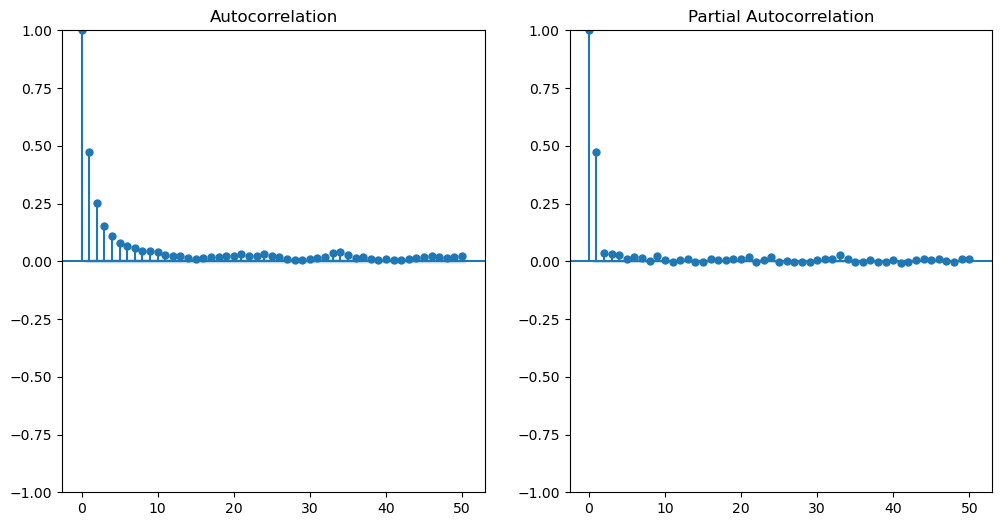

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF 및 PACF 시각화
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(data['vv'], lags=50, ax=plt.gca())
plt.subplot(122)
plot_pacf(data['vv'], lags=50, ax=plt.gca())
plt.show()

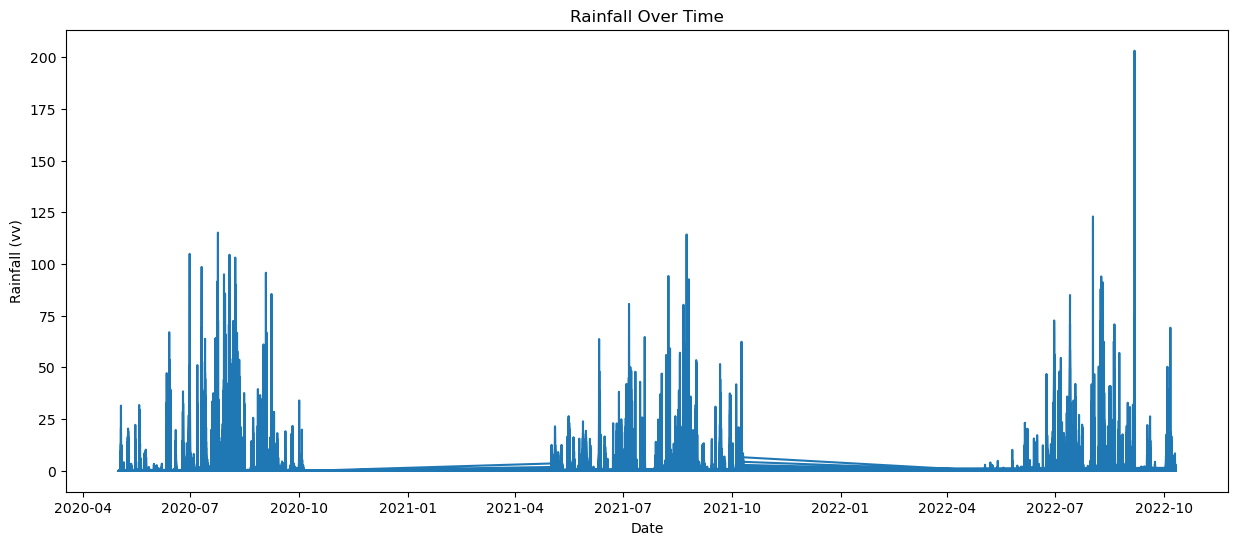

In [9]:
# 시간 변수 생성
data['datetime'] = pd.to_datetime(data[['year', 'month', 'day', 'hour']])

# 데이터 시각화
plt.figure(figsize=(15, 6))
plt.plot(data['datetime'], data['vv'])
plt.xlabel('Date')
plt.ylabel('Rainfall (vv)')
plt.title('Rainfall Over Time')
plt.show()

In [12]:
features = data[['stn4contest', 'year', 'month', 'day', 'hour', 'v01', 'v02', 'v03', 'v04', 'v05', 'v06', 'v07', 'v08', 'v09']]
target = data['vv']

In [15]:
# 스케일링
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features.drop(columns=['stn4contest']))
features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns[1:])
features_scaled_df['stn4contest'] = features['stn4contest'].values
features_scaled_df['vv'] = target.values

In [16]:
# 시퀀스 생성 함수
def create_sequences(data, target, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data.iloc[i:i + window_size].values)
        y.append(target.iloc[i + window_size])
    return np.array(X), np.array(y)

window_sizes = [3, 7, 24, 48]
results = {}

In [17]:
for window_size in window_sizes:
    X_train, y_train = [], []
    X_test, y_test = [], []
    
    for stn in features_scaled_df['stn4contest'].unique():
        stn_data = features_scaled_df[features_scaled_df['stn4contest'] == stn]
        stn_target = stn_data['vv']
        stn_data = stn_data.drop(columns=['stn4contest', 'vv'])
        
        X, y = create_sequences(stn_data, stn_target, window_size)
        
        if stn <= 16:
            X_train.append(X)
            y_train.append(y)
        else:
            X_test.append(X)
            y_test.append(y)
    
    # 리스트를 numpy 배열로 변환
    X_train = np.concatenate(X_train)
    y_train = np.concatenate(y_train)
    X_test = np.concatenate(X_test)
    y_test = np.concatenate(y_test)
    
    # GRU 모델 정의
    model = Sequential()
    model.add(GRU(units=64, return_sequences=True, input_shape=(window_size, X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(GRU(units=32))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    
    # 모델 컴파일
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    # 모델 학습
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
    
    # 모델 평가
    y_pred = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[window_size] = {
        'RMSE': rmse,
        'MAE': mae,
        'MSE': mse,
        'R²': r2
    }
    
print("Model Performance Metrics by Window Size:")
print(f"{'Window Size':<15}{'RMSE':<10}{'MAE':<10}{'MSE':<10}{'R²':<10}")
print(f"{'-'*45}")
for window_size, metrics in results.items():
    print(f"{window_size:<15}{metrics['RMSE']:<10.4f}{metrics['MAE']:<10.4f}{metrics['MSE']:<10.4f}{metrics['R²']:<10.4f}")

362/362 [==============================] - 6s 14ms/step
Model Performance Metrics by Window Size:
Window Size    RMSE      MAE       MSE       R²        
---------------------------------------------
3              3.4514    0.9590    11.9125   0.2778    
7              3.5235    0.8822    12.4151   0.2481    
24             3.5584    0.9626    12.6620   0.2306    
48             3.4816    0.8664    12.1213   0.2678    


### Best Params: {'units3': 32, 'units2': 64, 'units1': 32, 'learning_rate': 0.001, 'dropout_rate': 0.2}

In [12]:
# 필요한 열 선택 및 새로운 특징 추가
features = data[['stn4contest', 'v01', 'v02', 'v03', 'v04', 'v05', 'v06', 'v07', 'v08', 'v09', 'year', 'month', 'day', 'hour']]
target = data['vv']
#features['day_of_week'] = pd.to_datetime(features[['year', 'month', 'day']]).dt.dayofweek
#features['is_weekend'] = (features['day_of_week'] >= 5).astype(int)

# 스케일링
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features.drop(columns=['stn4contest']))
features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns[1:])
features_scaled_df['stn4contest'] = features['stn4contest'].values
features_scaled_df['vv'] = target.values

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# 시퀀스 생성 함수
def create_sequences(data, target, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data.iloc[i:i + lookback].values)
        y.append(target.iloc[i + lookback])
    return np.array(X), np.array(y)

In [9]:
lookbacks = [3, 24, 48]
results = {}
predictions = {}

# 최적의 하이퍼파라미터
best_params = {'units3': 32, 'units2': 64, 'units1': 32, 'learning_rate': 0.001, 'dropout_rate': 0.2}

for lookback in lookbacks:
    X_train, y_train = [], []
    X_test, y_test = [], []
    
    for stn in features_scaled_df['stn4contest'].unique():
        stn_data = features_scaled_df[features_scaled_df['stn4contest'] == stn]
        stn_target = stn_data['vv']
        stn_data = stn_data.drop(columns=['stn4contest', 'vv'])
        
        X, y = create_sequences(stn_data, stn_target, lookback)
        
        if stn <= 16:
            X_train.append(X)
            y_train.append(y)
        else:
            X_test.append(X)
            y_test.append(y)
    
    X_train = np.concatenate(X_train)
    y_train = np.concatenate(y_train)
    X_test = np.concatenate(X_test)
    y_test = np.concatenate(y_test)
    
    # 최적의 하이퍼파라미터로 모델 학습
    model = Sequential()
    model.add(Input(shape=(lookback, X_train.shape[2])))
    model.add(GRU(units=best_params['units1'], return_sequences=True))
    model.add(Dropout(best_params['dropout_rate']))
    model.add(GRU(units=best_params['units2'], return_sequences=True))
    model.add(Dropout(best_params['dropout_rate']))
    model.add(GRU(units=best_params['units3']))
    model.add(Dropout(best_params['dropout_rate']))
    model.add(Dense(1))
    
    optimizer = Adam(learning_rate=best_params['learning_rate'])
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
    
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0, callbacks=[early_stopping, model_checkpoint])
    
    # 모델 평가 및 예측 값 저장
    y_pred = model.predict(X_test)
    predictions[lookback] = (y_test, y_pred)
    loss = model.evaluate(X_test, y_test, verbose=0)
    results[lookback] = loss

# 성능 지표 계산 및 출력
print("Model Performance Metrics by Lookback:")
print(f"{'Lookback':<15}{'RMSE':<10}{'MAE':<10}{'MSE':<10}{'R²':<10}")
print(f"{'-'*45}")

for lookback, (y_test, y_pred) in predictions.items():
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{lookback:<15}{rmse:<10.4f}{mae:<10.4f}{mse:<10.4f}{r2:<10.4f}")

362/362 [==============================] - 6s 15ms/step
Model Performance Metrics by Lookback:
Lookback       RMSE      MAE       MSE       R²        
---------------------------------------------
3              3.4924    0.9096    12.1967   0.2606    
24             3.3825    0.8984    11.4412   0.3048    
48             3.3740    0.9254    11.3842   0.3124    


In [16]:
data = pd.read_csv("use_this.csv")

# 필요한 열 선택 및 새로운 특징 추가
features = data[['stn4contest', 'v01', 'v02', 'v03', 'v04', 'v05', 'v06', 'v07', 'v08', 'v09', 'year', 'month', 'day', 'hour']]
target = data['vv']

# 스케일링
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features.drop(columns=['stn4contest']))
features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns[1:])
features_scaled_df['stn4contest'] = features['stn4contest'].values
features_scaled_df['vv'] = target.values

# 관측소 기준으로 데이터 분리
train_data = features_scaled_df[features_scaled_df['stn4contest'] <= 16]
test_data = features_scaled_df[features_scaled_df['stn4contest'] > 16]

In [17]:
X_train = train_data.drop(columns=['vv']).values
y_train = train_data['vv'].values
X_test = test_data.drop(columns=['vv']).values
y_test = test_data['vv'].values

# 입력 데이터를 GRU 레이어에 맞게 재구성
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# GRU 모델 정의
model = Sequential()
model.add(Input(shape=(X_train.shape[1], 1)))
model.add(GRU(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=32, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=16))
model.add(Dropout(0.2))
model.add(Dense(1))

# 모델 컴파일
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# 조기 종료 및 모델 체크포인트
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# 모델 학습
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, verbose=0, callbacks=[early_stopping, model_checkpoint])

# 모델 평가
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# 성능 지표 출력
print(f"Model Performance Metrics:")
print(f"{'Metric':<10}{'Value':<20}")
print(f"{'-'*30}")
print(f"{'RMSE':<10}{rmse:<20.4f}")
print(f"{'MAE':<10}{mae:<20.4f}")
print(f"{'MSE':<10}{mse:<20.4f}")
print(f"{'R²':<10}{r2:<20.4f}")

366/366 [==============================] - 3s 6ms/step
Model Performance Metrics:
Metric    Value               
------------------------------
RMSE      3.2346              
MAE       0.8091              
MSE       10.4629             
R²        0.3652              


In [18]:
model.save('gru20.h5')

### gru 마지막

In [19]:
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

In [22]:
data = pd.read_csv('use_this.csv')

# 필요한 열 선택 및 새로운 특징 추가
features = data[['stn4contest', 'v01', 'v02', 'v03', 'v04', 'v05', 'v06', 'v07', 'v08', 'v09', 'year', 'month', 'day', 'hour']]
target = data['vv']

# 스케일링
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features.drop(columns=['stn4contest']))
features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns[1:])
features_scaled_df['stn4contest'] = features['stn4contest'].values
features_scaled_df['vv'] = target.values

# 관측소 기준으로 데이터 분리
train_data = features_scaled_df[features_scaled_df['stn4contest'] <= 16]
test_data = features_scaled_df[features_scaled_df['stn4contest'] > 16]

X_train = train_data.drop(columns=['vv']).values
y_train = train_data['vv'].values
X_test = test_data.drop(columns=['vv']).values
y_test = test_data['vv'].values

# 입력 데이터를 GRU 레이어에 맞게 재구성
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# 개선된 GRU 모델 정의
model = Sequential()
model.add(Input(shape=(1, X_train.shape[2])))
model.add(GRU(units=128, return_sequences=True, kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(GRU(units=64, return_sequences=True, kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(GRU(units=32, kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

# 모델 컴파일
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# 조기 종료 및 모델 체크포인트
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# 모델 학습
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0, callbacks=[early_stopping, model_checkpoint])

# 모델 평가
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# 성능 지표 출력
print(f"Model Performance Metrics:")
print(f"{'Metric':<10}{'Value':<20}")
print(f"{'-'*30}")
print(f"{'RMSE':<10}{rmse:<20.4f}")
print(f"{'MAE':<10}{mae:<20.4f}")
print(f"{'MSE':<10}{mse:<20.4f}")
print(f"{'R²':<10}{r2:<20.4f}")

366/366 [==============================] - 2s 3ms/step
Model Performance Metrics:
Metric    Value               
------------------------------
RMSE      3.3343              
MAE       0.7877              
MSE       11.1176             
R²        0.3255              


In [27]:
data = pd.read_csv('use_this.csv')

# 필요한 열 선택 및 새로운 특징 추가
features = data[['stn4contest', 'v01', 'v02', 'v03', 'v04', 'v05', 'v06', 'v07', 'v08', 'v09', 'year', 'month', 'day', 'hour']]
target = data['vv']

In [28]:
# 'stn4contest'을 카테고리형 변수로 변환
features = pd.get_dummies(features, columns=['stn4contest'])

# 날짜 시간 정보를 datetime 형식으로 변환
features['fc_datetime'] = pd.to_datetime(features[['year', 'month', 'day', 'hour']])

# 인덱스를 datetime으로 설정
features.set_index('fc_datetime', inplace=True)

# 불필요한 날짜 시간 열 제거
features.drop(['year', 'month', 'day', 'hour'], axis=1, inplace=True)

# 데이터 정렬
features = features.sort_index()

In [29]:
train_size = int(len(features) * 0.8)
train_features, test_features = features[:train_size], features[train_size:]
train_target, test_target = target[:train_size], target[train_size:]

In [32]:
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))

train_features_scaled = scaler_features.fit_transform(train_features)
test_features_scaled = scaler_features.transform(test_features)

train_target_scaled = scaler_target.fit_transform(train_target.values.reshape(-1, 1))
test_target_scaled = scaler_target.transform(test_target.values.reshape(-1, 1))

In [33]:
def create_dataset(features, target, time_step=1):
    dataX, dataY = [], []
    for i in range(len(features)-time_step-1):
        a = features[i:(i+time_step)]
        dataX.append(a)
        dataY.append(target[i + time_step])
    return np.array(dataX), np.array(dataY)

# 타임스텝 설정
time_steps = [8, 16, 24]

# 결과를 저장할 딕셔너리
results = {}

In [37]:
import math

for time_step in time_steps:
    # 데이터 구조화
    X_train, y_train = create_dataset(train_features_scaled, train_target_scaled, time_step)
    X_test, y_test = create_dataset(test_features_scaled, test_target_scaled, time_step)
    
    # LSTM 입력 형식에 맞게 데이터 재구조화 [samples, time steps, features]
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])
    
    # 모델 구성
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # 모델 훈련
    model.fit(X_train, y_train, batch_size=32, epochs=30)
    
    # 예측
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)
    
    # 예측 데이터 역정규화
    train_predict = scaler_target.inverse_transform(train_predict)
    test_predict = scaler_target.inverse_transform(test_predict)
    
    # 실제 데이터 역정규화
    y_train_actual = scaler_target.inverse_transform(y_train)
    y_test_actual = scaler_target.inverse_transform(y_test)
    
    # 성능 지표 계산
    train_rmse = math.sqrt(mean_squared_error(y_train_actual, train_predict))
    test_rmse = math.sqrt(mean_squared_error(y_test_actual, test_predict))
    train_mae = mean_absolute_error(y_train_actual, train_predict)
    test_mae = mean_absolute_error(y_test_actual, test_predict)
    train_mse = mean_squared_error(y_train_actual, train_predict)
    test_mse = mean_squared_error(y_test_actual, test_predict)
    train_r2 = r2_score(y_train_actual, train_predict)
    test_r2 = r2_score(y_test_actual, test_predict)
    
    # 결과 저장
    results[time_step] = {
        'Train RMSE': train_rmse, 'Test RMSE': test_rmse,
        'Train MAE': train_mae, 'Test MAE': test_mae,
        'Train MSE': train_mse, 'Test MSE': test_mse,
        'Train R²': train_r2, 'Test R²': test_r2
    }

# 결과 출력
results_df = pd.DataFrame(results).T
results_df.index.name = 'Time Step'
results_df.columns = ['Train RMSE', 'Test RMSE', 'Train MAE', 'Test MAE', 'Train MSE', 'Test MSE', 'Train R²', 'Test R²']

import ace_tools as tools; tools.display_dataframe_to_user(name="LSTM Time Step Results", dataframe=results_df)

print(results_df)

Epoch 1/30
1950/1950 [==============================] - 23s 10ms/step - loss: 4.6143e-04
Epoch 2/30
1950/1950 [==============================] - 21s 11ms/step - loss: 4.5761e-04
Epoch 3/30
1950/1950 [==============================] - 19s 10ms/step - loss: 4.5767e-04
Epoch 4/30
1950/1950 [==============================] - 19s 10ms/step - loss: 4.5778e-04
Epoch 5/30
1950/1950 [==============================] - 19s 10ms/step - loss: 4.5796e-04
Epoch 6/30
1950/1950 [==============================] - 19s 10ms/step - loss: 4.5784e-04
Epoch 7/30
1950/1950 [==============================] - 19s 10ms/step - loss: 4.5778e-04
Epoch 8/30
1950/1950 [==============================] - 19s 10ms/step - loss: 4.5781e-04
Epoch 9/30
1950/1950 [==============================] - 19s 10ms/step - loss: 4.5803e-04
Epoch 10/30
1950/1950 [==============================] - 19s 10ms/step - loss: 4.5780e-04
Epoch 11/30
1950/1950 [==============================] - 19s 10ms/step - loss: 4.5824e-04
Epoch 12/30
1950/19

1950/1950 [==============================] - 58s 30ms/step - loss: 4.5807e-04
Epoch 30/30
487/487 [==============================] - 4s 8ms/step


ModuleNotFoundError: No module named 'ace_tools'

In [39]:
results_df

,Train RMSE,Test RMSE,Train MAE,Test MAE,Train MSE,Test MSE,Train R²,Test R²
Time Step,,,,,,,,
8,4.346618,4.254975,1.654276,1.640393,18.893086,18.104811,-0.003226,-0.004068
16,4.345235,4.250258,1.285968,1.266587,18.881069,18.064691,-0.002464,-0.001998
24,4.343943,4.252095,1.601582,1.586302,18.869837,18.080313,-0.001744,-0.002374
